In [2]:
# cd "C:\Users\leyla\OneDrive - Universitetet i Agder\Biomedical Signal\My_Project_MAS509"
# If pb with environment : Select interpeter (ctrl + shift + p), then kernel

In [37]:
import tensorflow as tf     #deep learning
import numpy as np          #Arrays & maths operations
import pandas as pd         # data handling (dataFrames)
import matplotlib.pyplot as plt      #ploting graphs
import seaborn as sns               # Statistical data visualization
from sklearn.preprocessing import StandardScaler    # Normalize features
from sklearn.model_selection import train_test_split    # split data train/test
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import StratifiedKFold   # model evaluation
import csv      # Read and write csv files

In [38]:
data_emg = pd.read_csv("C:/Users/leyla/OneDrive - Universitetet i Agder/Biomedical Signal/Olimex-EMG data acquisition/All_processed_data.csv", sep=";")
data_emg = np.array(data_emg)   #convert to NumPy array for processing
np.shape(data_emg)              # check shape: (rows, columns)

(400, 103)

In [39]:
# Separate labels (y) and features (x)
y = data_emg[:,[-1]].astype(int) # Extract last column as integers labels
x = data_emg[:, :-1]            # Extract all columns except the last as features
n_channel = 1               # Define nb channels (1 for EMG, 3 for accelerometer)
x = x.reshape(x.shape[0], x.shape[1], n_channel)    #reshape to 3d tensor for sequential models
np.shape(x)             # output shape (samples, time_steps, channels)

print("Shape x :", x.shape)
print("Shape y : ", y.shape)

Shape x : (400, 102, 1)
Shape y :  (400, 1)


In [40]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=100) # split data : 70% train 30% test
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [41]:
def build_model(normalizer_layer):

    num_class = 2
    base_model = tf.keras.models.Sequential([
        normalizer_layer,

        tf.keras.layers.Conv1D(filters=32, kernel_size=3),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
    
        tf.keras.layers.Conv1D(filters=64, kernel_size=3),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Conv1D(filters=64, kernel_size=3),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),

        tf.keras.layers.Conv1D(filters=64, kernel_size=3),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(num_class, activation='softmax')

    ])
    # Prepares the model for training
    base_model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    return base_model


In [43]:

#CROSS VALIDATION (5-FOLD)

k = 5
# StratifiedKFold ensures label balance in each fold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_accuracies = []  #store accuracy for each fold
cv_losses = []  #store loss for each fold

# List to store curves dor averaging across folds
fold_train_loss = []
fold_val_loss = []
fold_train_acc = []
fold_val_acc = []

fold_number = 1

for train_index, val_index in skf.split(x, y.reshape(-1)):
    print(f"\n=======================FOLD {fold_number}/{k} =====================")

    #Split train/validation using indices from StratifiedKFold
    x_train_fold, x_val_fold = x[train_index], x[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    #Fit normalizer on FULL dataset for final training
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train_fold)

    #Build a fresh model for this fold
    model = build_model(normalizer)

    # Train with early stopping
    # Stops training if the validation loss doesn't improve for a specified number of epochs (patience)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',             #Monitor validation loss during training
        patience=15,                    # Wait 15 epochs before stopping if no improvement
        restore_best_weights=True       # Restore the weight from the best epoch
    )

    #Training is now done per fold
    history = model.fit(
        x_train_fold, y_train_fold,
        validation_data=(x_val_fold, y_val_fold),          
        batch_size=32,                  # Nb of samples per training batch
        epochs=50,
        callbacks=[tf.keras.callbacks.ReduceLROnPlateau(), early_stopping]      # Reduce learning rate if validation loss stagnates
                                                                                # Apply early stopping if needed
    )

    # Save curves for averaging later
    fold_train_loss.append(history.history["loss"])
    fold_val_loss.append(history.history["val_loss"])
    fold_train_acc.append(history.history["accuracy"])
    fold_val_acc.append(history.history["val_accuracy"])

    # Evaluate the fold performance
    loss, acc = model.evaluate(x_val_fold, y_val_fold, verbose=0)

    #Store metrics
    cv_accuracies.append(acc)
    cv_losses.append(loss)

    print(f"Fold {fold_number} accuracy = {acc:.4f}")
    print(f"Fold {fold_number} loss = {loss:.4f}")

    fold_number +=1

print("\n=============FINAL CROSS-VALIDATION RESULTS ==============")
print("Accuracy per fold : ", cv_accuracies)
print("Mean accuracy : ", np.mean(cv_accuracies))
print("Std accuracy :",np.std(cv_accuracies))

#FINAL MODEL TRAINED ON ALL DATA 
#(for saving and generating final confusion matrix)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x)

# Build a final model based on all available data
final_model = build_model(normalizer)

history = final_model.fit(
    x, y,
    epochs=50,
    batch_size=32,
    verbose=1       #ce qui est affiché dans la console (1 = détaillé)
)

# SAVE
final_model.save("MY_FINAL_ML_CV.keras")      #Creates a folder with model structure + weights + optimizer state

# Save weights only
#model.save_weights("my_weights.h5")

final_model.summary()    # model summary


=======================FOLD 1/5 =====================
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6687 - loss: 2.2228 - val_accuracy: 0.7500 - val_loss: 2.0120 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7437 - loss: 1.8508 - val_accuracy: 0.7625 - val_loss: 1.6734 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7625 - loss: 1.5558 - val_accuracy: 0.7750 - val_loss: 1.4091 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7563 - loss: 1.3046 - val_accuracy: 0.8375 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7906 - loss: 1.0906 - val_accuracy: 0.8500 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8094 - loss: 0.9096 - val_accuracy: 0.8750 - val_loss: 0.8250 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_47                │ (None, 102, 1)         │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_188 (Conv1D)             │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_188 (Activation)     │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_188               │ (None, 50, 32)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_189 (Conv1D)             │ (None, 48, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_189 (Activation)     │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_189               │ (None, 24, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_190 (Conv1D)             │ (None, 22, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_190 (Activation)     │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_190               │ (None, 11, 64)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_191 (Conv1D)             │ (None, 9, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_191 (Activation)     │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_191               │ (None, 4, 64)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,587 (752.30 KB)

 Trainable params: 64,194 (250.76 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 128,390 (501.53 KB)

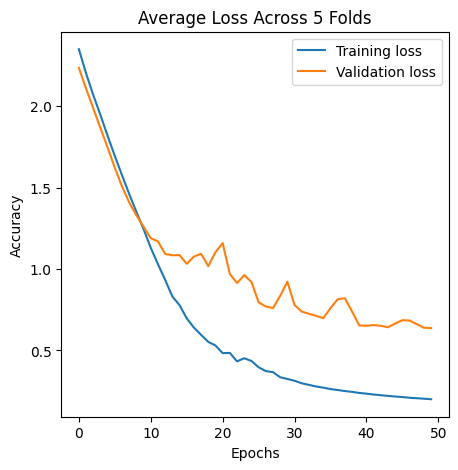

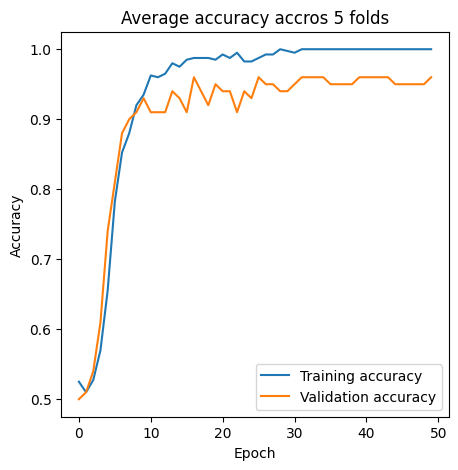

In [35]:
#Find max length among all the folds
max_len = max([len(h) for h in fold_train_loss])

#Add last value to complete each fold
fold_train_loss_padded = [h +[h[-1]]*(max_len - len(h)) for h in fold_train_loss]
fold_val_loss_padded = [h +[h[-1]]*(max_len - len(h)) for h in fold_val_loss]
fold_train_acc_padded = [h +[h[-1]]*(max_len - len(h)) for h in fold_train_acc]
fold_val_acc_padded = [h +[h[-1]]*(max_len - len(h)) for h in fold_val_acc]

mean_train_loss = np.mean(fold_train_loss_padded, axis=0)
mean_val_loss = np.mean(fold_val_loss_padded, axis=0)
mean_train_acc = np.mean(fold_train_acc_padded, axis=0)
mean_val_acc = np.mean(fold_val_acc_padded, axis=0)

num_epochs = len(mean_train_loss)

#------------LOSS---------------
plt.figure(figsize=(5,5))
plt.plot(range(num_epochs), mean_train_loss, label='Training loss')
plt.plot(range(num_epochs), mean_val_loss, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Average Loss Across 5 Folds")
plt.show()

#---------ACCURACY---------------
plt.figure(figsize=(5,5))
plt.plot(range(num_epochs), mean_train_acc, label='Training accuracy')
plt.plot(range(num_epochs), mean_val_acc, label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Average accuracy accros 5 folds")
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0701 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


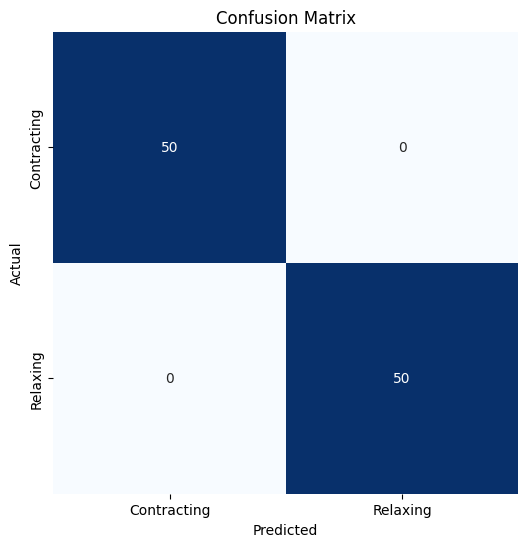

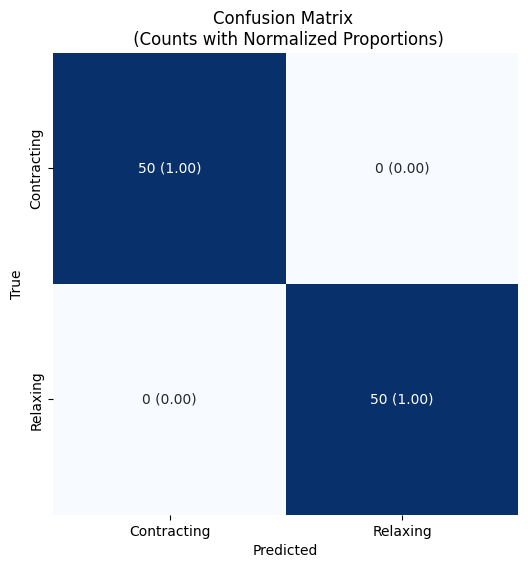

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [36]:

final_model.evaluate(x, y)         # evaluate on test data set
y_true = np.array(y)                   # ground truth label
y_pred = np.array([np.argmax(p) for p in final_model.predict(x)])     # predicted label

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Row-wise normalization (axis=1) shows recall / sensitivity per class
# col wise normalization (axis=0) shows precision

class_names = ['Contracting', 'Relaxing']
# sns.heatmap(..., xticklabels=class_names, ytick_labels=class_names)   # pour afficher les noms des classes

plt.figure(figsize=(6,6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='g', 
    cmap='Blues', 
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print normalized and unnormalized value
annot = np.array([
    [f"{cm[i,j]} ({cm_normalized[i,j]:.2f})"
     for j in range(cm.shape[1])]
     for i in range(cm.shape[0])
])

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=annot,        # Combined values
    fmt='',             # Disable default formatting
    cmap="Blues",
    cbar=False,
    linewidths=0.8,
    linecolor='none',
    annot_kws={"size": 10},     # Adjust font size
    xticklabels=class_names, yticklabels=class_names
)

plt.title("Confusion Matrix \n (Counts with Normalized Proportions)")
plt.xlabel("Predicted")
plt.ylabel('True')
plt.show()


print(classification_report(y_true, y_pred))

